# Train custom data
실제 데이터를 학습 데이터로 활용해 봅니다.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

('Input img size:', (721, 960, 3))
Number of faces: 1
('Bounding box:', (362, 64, 301, 301))


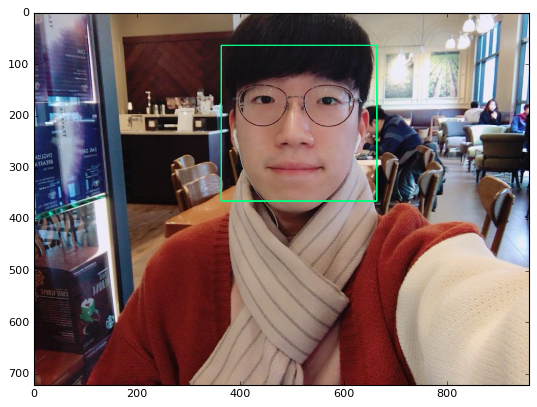

In [2]:
face_cascade_ocv = cv2.CascadeClassifier('./models/opencv-cascade/haarcascade_frontalface_alt.xml')
img_bgr = cv2.imread('./data/tkwoo_test.jpeg', 1)
show = img_bgr.copy()
# image shape = (height, width, channel)
print ('Input img size:',img_bgr.shape)

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
bbox_faces = face_cascade_ocv.detectMultiScale(img_gray, 1.3, 5) # x,y,w,h

print ('Number of faces: %d'%len(bbox_faces))

for (x,y,w,h) in bbox_faces:
    cv2.rectangle(show, (x,y),(x+w,y+h), (128,255,0),2)
    # cropped_img = img_bgr[x:x+w, y:y+h]
    bbox = (x,y,w,h)
    cropped_img = img_bgr[y:y+h, x:x+w]

if len(bbox_faces)==0:
    bbox = (10,10,100,100)
    x,y,w,h = bbox
    cv2.rectangle(show, (x,y),(x+w,y+h), (0,0,255),2)
    cropped_img = img_bgr[y:y+h, x:x+w]
    
print ('Bounding box:', bbox)
show = cv2.cvtColor(show, cv2.COLOR_BGR2RGB)
plt.imshow(show)
plt.show()

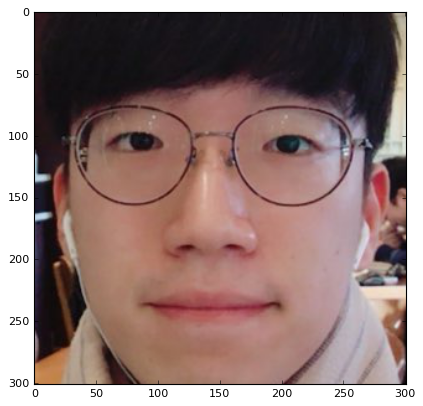

In [3]:
cropped_show = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_show)
plt.show()

Using TensorFlow backend.


[  5.55842519e-02   5.43712085e-05   3.77455018e-02   6.86101965e-04
   6.13407455e-02   8.83309692e-02   7.56258070e-01]
label: Neutral


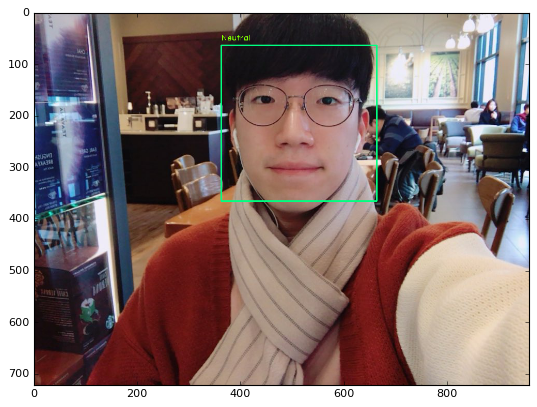

In [4]:
### classification
from keras.models import Model, model_from_json
import keras
import xception_model

model = xception_model.XCEPTION()
model.load_weights('./models/xception/weights.20_0.61.h5') #'models/xception/weights.79.h5'

### model input
resized_img = cv2.resize(cropped_img, (48,48))
img_bgr_float = resized_img.astype(np.float32)
img_bgr_float_normalized = 2*(img_bgr_float - 128)/255

### make gray 3ch for xception network
img_cropgray_1ch = cv2.cvtColor(img_bgr_float_normalized, cv2.COLOR_BGR2GRAY)
img_cropgray_3ch = cv2.cvtColor(img_cropgray_1ch, cv2.COLOR_GRAY2BGR)

img_input = np.expand_dims(img_cropgray_3ch, 0)

result = model.predict(img_input, 1)

# result is a softmax value of emotion labels
# the order is same with below dictionary data
print (result[0])

# final label is a order of maximum value
predict_label = np.argmax(result[0])

dict_emotion_label = {0:'Angry',1:'Disgust',2:'Fear',
                      3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

print ('label: %s'%dict_emotion_label[predict_label])

cv2.putText(show, '%s'%dict_emotion_label[predict_label], 
            (bbox_faces[0][0], bbox_faces[0][1]-10),
            cv2.FONT_HERSHEY_DUPLEX, 
            0.5, 
            (127,255,0))
plt.imshow(show)
plt.show()

./data/train_own/.DS_Store
./data/train_own/03.Happy/tkwoo.png


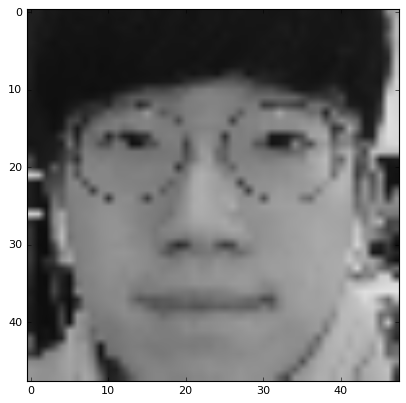

In [5]:
resized_img = cv2.resize(cropped_img, (48,48))
resized_gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('./data/train_own/03.Happy/tkwoo.png', resized_gray_img)

for (path, dir, files) in os.walk("./data/train_own"):
    for filename in files:
        img_path = "%s/%s" % (path, filename)
        print("%s/%s" % (path, filename))
training_img = cv2.imread(img_path, 1)
plt.imshow(training_img)
plt.show()

In [6]:
def centering(np_image):
    return 2*(np_image - 128)

In [7]:
from keras.optimizers import Adam

In [8]:
model.compile(optimizer=Adam(lr=0.001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import math
import cv2
import numpy as np
import os
from glob import glob
import argparse
from keras.utils import plot_model

In [10]:
img_size = 48
batch_size = 1

train_datagen = ImageDataGenerator(
            preprocessing_function=centering,
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
            )

In [11]:
train_generator = train_datagen.flow_from_directory(
            './data/train_own',
            target_size=(img_size, img_size),
            batch_size=batch_size,
            # color_mode='grayscale',
            class_mode='categorical')

Found 1 images belonging to 7 classes.


In [12]:
flgUsePretrainedWeight = True
if flgUsePretrainedWeight == True:
    model.load_weights('./models/xception/weights.20_0.61.h5')
    print ("[*] loaded pretrained model weight")

[*] loaded pretrained model weight


In [13]:
if not os.path.exists('./models/new_xception'):
    os.mkdir('./models/new_xception')
    
model_json = model.to_json()
with open('./models/new_xception/model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.summary()
# plot_model(model, to_file='./models/new_xception/model.png')
# graph_model = cv2.imread('./models/new_xception/model.png', 1)
# import matplotlib.pyplot as plt
# plt.imshow(graph_model)
# plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 23, 23, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 23, 23, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 23, 23, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n // batch_size,
        epochs=20,
        )

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 4.4646 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 48ms/step - loss: 3.7170 - acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 125ms/step - loss: 0.3885 - acc: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 208ms/step - loss: 0.0905 - acc: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 207ms/step - loss: 0.0123 - acc: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 206ms/step - loss: 8.4102e-04 - acc: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 212ms/step - loss: 0.0012 - acc: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 194ms/step - loss: 2.4677e-05 - acc: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 210ms/step - loss: 6.5388e-05 - acc: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 102ms/step - loss: 8.1063e-06 - acc: 1.0000
Epoch 11/20
1/1 [==============================] 

[  2.98193825e-09   7.83928963e-11   1.36356015e-09   9.99999285e-01
   6.91576796e-09   2.24207795e-07   4.30545668e-07]
label: Happy


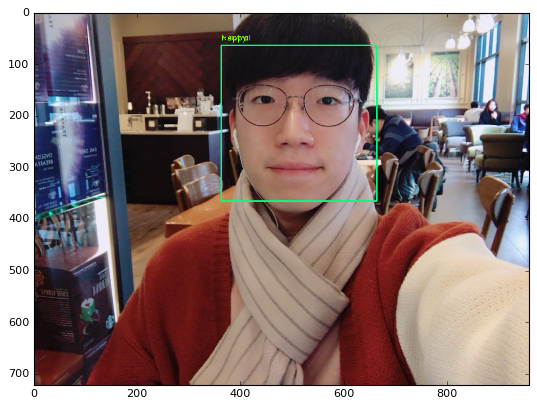

In [15]:
resized_img = cv2.resize(cropped_img, (48,48))
img_bgr_float = resized_img.astype(np.float32)
img_bgr_float_normalized = 2*(img_bgr_float - 128)/255

### make gray 3ch for xception network
img_cropgray_1ch = cv2.cvtColor(img_bgr_float_normalized, cv2.COLOR_BGR2GRAY)
img_cropgray_3ch = cv2.cvtColor(img_cropgray_1ch, cv2.COLOR_GRAY2BGR)

img_input = np.expand_dims(img_cropgray_3ch, 0)

result = model.predict(img_input, 1)

# result is a softmax value of emotion labels
# the order is same with below dictionary datat
print (result[0])

# final label is a order of maximum value
predict_label = np.argmax(result[0])

# dict_emotion_label = {0:'neutral',1:'happiness',2:'surprise',
#                       3:'sadness',4:'anger',5:'disgust',
#                       6:'fear',7:'contempt',9:'unknown'}
dict_emotion_label = {0:'Angry',1:'Disgust',2:'Fear',
                      3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

print ('label: %s'%dict_emotion_label[predict_label])

# cv2.imshow('crop', cropped_img)
# cv2.imshow('show', show)
# cv2.waitKey()
cv2.putText(show, '%s'%dict_emotion_label[predict_label], 
            (bbox_faces[0][0], bbox_faces[0][1]-10),
            cv2.FONT_HERSHEY_DUPLEX, 
            0.5, 
            (127,255,0))
plt.imshow(show)
plt.show()